In [11]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.tensorboard import SummaryWriter

import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

from torchcfm.conditional_flow_matching import *
from models_v2 import *
from torchcfm.utils import *
from torchcfm.optimal_transport import OTPlanSampler

from tqdm import tqdm
import imageio

from utils_hf import *

savedir = "models/lin_pot_8gauss_moon"
os.makedirs(savedir, exist_ok=True)



In [12]:
# Problem set up

dim = 2
batch_size = 256
n_iters = 20_000
architecture = 'MLP'
ot_sampler = OTPlanSampler(method="exact")

In [3]:
mean = torch.zeros(dim)
cov = torch.eye(dim)

# Set up for reference distribution

ref_dist = MultivariateNormal(mean, cov)


In [13]:
sigma = 0.15
U = torch.tensor([[3, 1], [0, 5]], dtype=torch.float32)
sqt_tr_U = torch.sqrt(torch.trace(U))
D,Q = torch.linalg.eigh(U)
# model_ent_match = ResNet(dim= dim,hidden=2,time_varying= True)
if architecture == 'MLP':
    model_harmonic = ResNet(dim= dim,w=64,time_varying= True)
else: 
    model_harmonic = MLP(dim= dim,w=64,time_varying= True)
optimizer = torch.optim.Adam(model_harmonic.parameters(), lr=1e-3)

In [28]:
# # To change the learning rate
# for param_group in optimizer.param_groups:
#     param_group['lr'] = 1e-5

Loss: 41.378:   0%|          | 0/20000 [00:00<?, ?it/s]

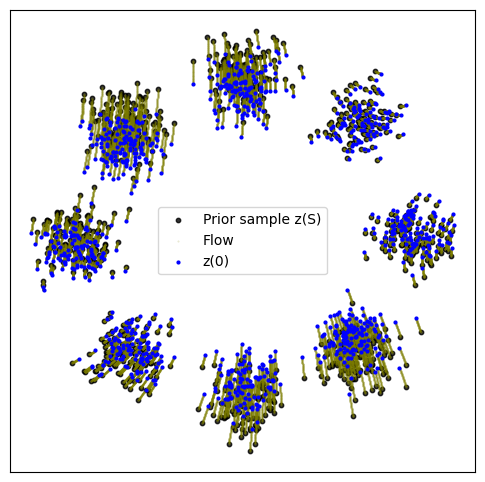

Loss: 1.922:  25%|██▌       | 5000/20000 [02:01<06:11, 40.41it/s] 

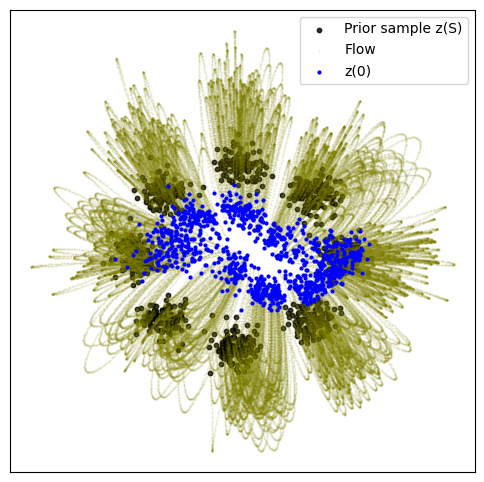

Loss: 1.528:  50%|█████     | 10000/20000 [03:52<04:07, 40.33it/s]

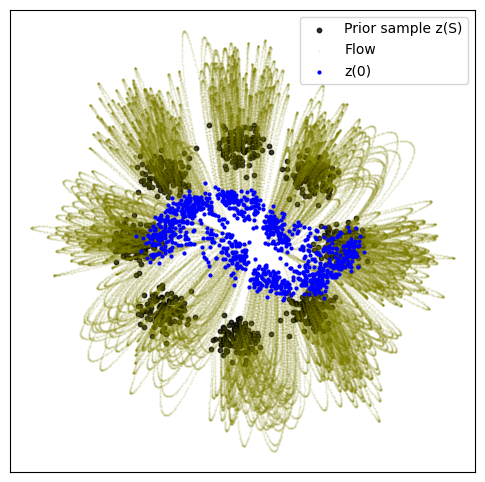

Loss: 1.490:  75%|███████▌  | 15000/20000 [05:36<01:26, 57.94it/s]

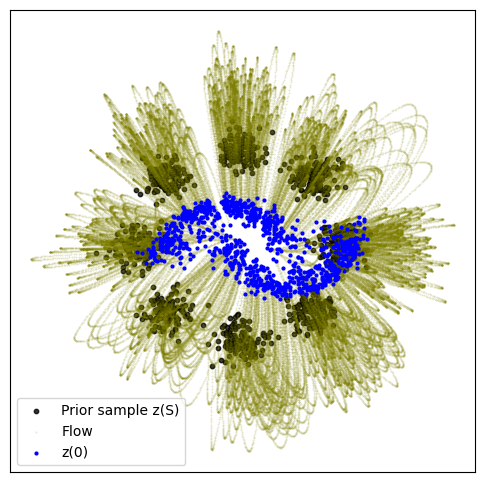

100%|██████████| 20000/20000 [07:25<00:00, 44.85it/s]0, 38.95it/s]


In [29]:

FM = HarmonicOscillatorConditionalFlowMatcher(U = U,sigma= sigma,ot_method= "exact")
pbar = tqdm(total=n_iters, desc="Training")
writer = SummaryWriter()
for k in tqdm(range(n_iters)):
    optimizer.zero_grad()

    t = torch.rand((batch_size,1))

    # #x0 = ref_dist.sample((batch_size,))
    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)

    x0, x1 = ot_sampler.sample_plan(x0, x1)

    x0 = x0.unsqueeze(-1)
    x1 = x1.unsqueeze(-1)
    

    D_t = D**0.5 * t
    cos_D_t = torch.diag_embed(torch.cos(D_t))
    sin_D_t = torch.diag_embed(torch.sin(D_t))
    cos_D_1 = torch.diag(torch.cos(D**.5))
    inv_sin_D_1 = torch.diag(torch.sin(D**.5)**-1)

    mu_t = (Q@(cos_D_t@Q.T@x0 + sin_D_t@inv_sin_D_1@(-cos_D_1@Q.T@x0+Q.T@x1))).squeeze(-1)
    mu_t_prime = (Q@torch.diag_embed(D**.5)@(-sin_D_t@Q.T@x0 + cos_D_t@inv_sin_D_1@(-cos_D_1@Q.T@x0+Q.T@x1))).squeeze(-1)

    sig_t = sigma*(torch.cos(sqt_tr_U*t) + torch.sin(sqt_tr_U*t)*(1-torch.cos(sqt_tr_U))/(torch.sin(sqt_tr_U)+1e-8))

    sig_t_prime = sigma*sqt_tr_U*(-torch.sin(sqt_tr_U*t) + torch.cos(sqt_tr_U*t)*(1-torch.cos(sqt_tr_U))/(torch.sin(sqt_tr_U)+1e-8))
    epsilon = torch.randn_like(x0).squeeze(-1)
    
    xt = mu_t + sig_t*epsilon
    ut = sig_t_prime*(xt-mu_t)/(sig_t+1e-8) + mu_t_prime

    # t,xt,ut = FM.sample_location_and_conditional_flow(x0, x1)

    # print(t.shape,xt.shape,ut.shape)

    vt = model_harmonic(torch.cat([xt,t],dim = -1))
    # loss = torch.mean(torch.norm(vt - ut)**2)
    loss = torch.nn.MSELoss()(vt,ut)
    writer.add_scalar('Loss', loss.item(), k)

    # Update the progress bar
    pbar.set_description("Loss: %.3f" % loss.item())
    pbar.update()
    

    loss.backward()
    optimizer.step()

    if (k ) % 5000 == 0:
        node = NeuralODE(
            torch_wrapper(model_harmonic), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            # print(loss.item())
            traj = node.trajectory(
                #ref_dist.sample((1000,)),
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())



In [52]:
torch.save(model_harmonic.state_dict(), os.path.join(savedir, f"harmonic_model_{architecture}_8g_moons_25000.pt"))

In [14]:
state_dict = torch.load(os.path.join(savedir, f"harmonic_model_{architecture}_8g_moons_25000.pt"))
model_harmonic = MLP(dim= dim,w=64,time_varying= True)
model_harmonic.load_state_dict(state_dict)
model_harmonic.eval()

MLP(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): SELU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): SELU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): SELU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)

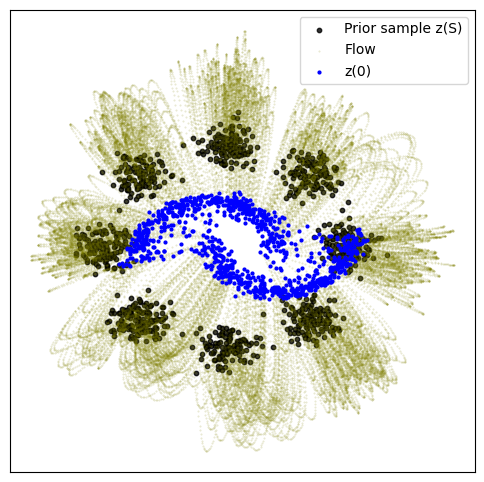

In [15]:
node = NeuralODE(torch_wrapper(model_harmonic), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
with torch.no_grad():
    traj = node.trajectory(
                #ref_dist.sample((1000,)),
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 50),
            )
    plot_trajectories(traj.cpu().numpy())
#     plt.savefig(os.path.join(savedir,f"traj_MLP_15_000.png"))

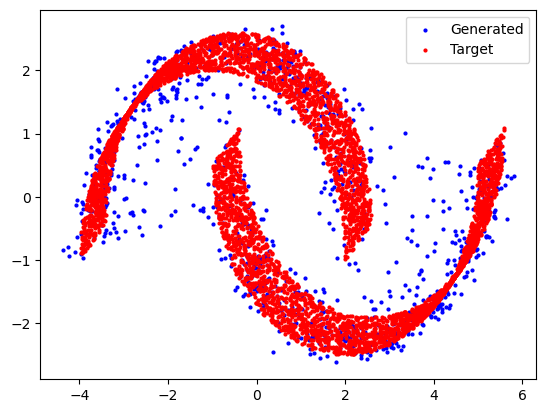

In [16]:
n = 2000
plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")
samples = sample_moons(5000)
plt.scatter(samples[:, 0], samples[:, 1], s=4, alpha=1, c="red")
plt.legend(["Generated", "Target"])
plt.show()
# plt.savefig(os.path.join(savedir,f"traj_MLP_15_000_comp.png"))

In [17]:

# Generate a grid of points

num_samples = 1000
xx0 = sample_8gaussians(num_samples)
gif_quiver(model_harmonic,savedir,xx0,num_samples,N = 50)


In [20]:

particle_gif(model_harmonic,savedir,xx,gg,N = 50)


Computation of Hamiltonian on the trajectory. 

Recall 

$$
H(\rho,v) = \mathbb{E}_{\rho(x,t)}(0.5||v||^2+V(x)) \approx \frac{1}{k}\sum_i(0.5||v(x_i,t)||^2+V(x_i))
$$
for $x_i\sim \rho(\cdot,t)$

In [28]:
def potential(x):

    Ux = x@U

    return 0.5*(Ux*x).sum(-1)
    

In [78]:
N = 100
t = torch.linspace(0, 1, N)
num_samples = 5_000
x0 = sample_8gaussians(num_samples)
hamiltonian = np.zeros(N)
U = torch.tensor([[3, 1], [0, 5]], dtype=torch.float32)

In [79]:

node = NeuralODE(torch_wrapper(model_harmonic), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4        )
with torch.no_grad():
    traj = node.trajectory(x0,t_span=torch.linspace(0, 1, N))



    

In [80]:
for i in range(N):

    tt = t[i]*torch.ones((num_samples,1))

    pot = potential(traj[i]).mean()

    kinetic = 0.5*(torch.linalg.vector_norm(model_harmonic(torch.cat([traj[i],tt],dim = -1)),dim = -1)**2).mean() 
    
    hamiltonian[i] = pot +  kinetic



In [81]:
relative_error = (hamiltonian - hamiltonian[0])/hamiltonian[0]

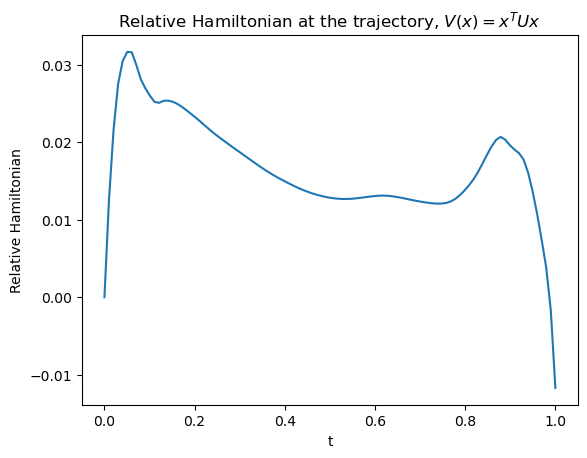

In [82]:
plt.plot(t,relative_error)
plt.title("Relative Hamiltonian at the trajectory, $V(x) = x^TUx$")
plt.xlabel("t")
plt.ylabel("Relative Hamiltonian")
plt.savefig(os.path.join(savedir,f"hamiltonian_relative_error_small_exp.png"))

In [83]:
256*2

512